# IF240 - Apprentissage et deep learning

## Assignment 1: Kmeans, Naive Bayes, SVM 

By Aurélie Bugeau


<font color="blue"/>

### Objectifs
L'objectif est d'appliquer des algorithmes de classifications pour la reconnaissance de chiffres.

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt 

# Récupère les digits avec une méthode préexistante : images, les classes correspondantes
# 1797 images de taille 8*8 pixels
digits = load_digits()

<font color="blue"/>

### Question 1 : Kmeans

La méthode de Machine learning de cette partie concerne la méthode **non supervisée** de classification des K-moyennes (nommée *KMeans*). Comme tout algorithme non supervisé, le but est d'apprendre depuis les données et d'en ressortir des informations, en l'occurrence séparer les données, des vecteurs 8\*8, en k classes distinctes, 10 en l'occurrence.

L'algorithme est plutôt simple : nous prenons k centroids aléatoires au depart, pour chaque point nous l'attribuons au centroid le plus proche. Ensuite, une fois que tous les points ont été assignés, nous prenons la moyenne de la positions de ces points afin de recréer un nouveau centroids pour chaque classe et répéter jusqu'à la convergence des positions des centroids.

Ici le but est d'appliquer cet algorithme sur des images à savoir un vecteur 8\*8, donc 64 pixels. Le but est donc d'aplatir toutes les données, effectuer l'algorithme et quand il y a convergence, alors nous allons redimensionner le vecteur afin de le remettre en tant qu'image. Nous avons donc les images moyennes pour chacune des classes.

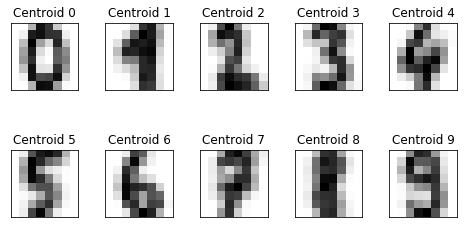

In [2]:
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn import metrics
import numpy as np
from seaborn import heatmap

# Données (tableau de 1797 images de dimension 8*8)
X_kmeans=digits.data
Y_kmeans=digits.target

# Nombre de classes que l'on souhaite avoir : 10 digits
n_clusters = 10

# Dimensions d'une image : 8,8
image_shape = digits.images.shape[1:]

# Applique KMeans sur nos données
clustering = KMeans(n_clusters, random_state = 0).fit(X_kmeans)

# Récupères les résultats : les centroids et les labels correspondants
centroids = clustering.cluster_centers_
centroids_labels = clustering.labels_

# Créé un tableau avec pour chaque classes, les images correspondantes (tableau de taille 10,8,8)
images_centroids = np.zeros((n_clusters,image_shape[0],image_shape[1]))

# Redimensioner les données afin d'obtenir des images 8*8
for i in range(n_clusters):
    images_centroids[i] = np.reshape(centroids[i], image_shape)

# Attribuer les vrais labels aux données par rapport aux données initiales
labels = np.zeros_like(Y_kmeans)
for i in range(n_clusters):
    indices = np.where(centroids_labels == i)[0]
    labels[indices] = mode(Y_kmeans[indices])[0]
    images_centroids[mode(Y_kmeans[indices])[0]] = np.reshape(centroids[i], image_shape)

# Afficher les images des centroids
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
i=0
for axi in ax.flat:
    axi.set(xticks=[], yticks=[])
    axi.set_title("Centroid %d"%i)
    axi.imshow(images_centroids[i], interpolation='nearest', cmap=plt.cm.binary)
    i+=1

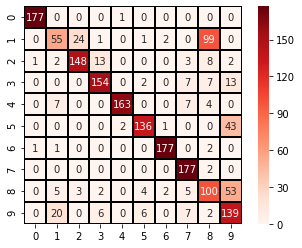

In [3]:
# Nous obtenons les résultats dans la matrice de confusion
confution_matrix = metrics.confusion_matrix(Y_kmeans, labels, labels=range(n_clusters))

# On l'affiche sur une heatmap
ax = heatmap(confution_matrix, annot=True, cmap="Reds", square=True, linecolor="black", fmt='d', linewidths = 1)

# Centrer la heatmap
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

In [4]:
# Pour tous les labels, renvoit les métriques principales
report_kmeans = metrics.classification_report(Y_kmeans, labels)
print(report_kmeans)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       178
           1       0.61      0.30      0.40       182
           2       0.85      0.84      0.84       177
           3       0.88      0.84      0.86       183
           4       0.98      0.90      0.94       181
           5       0.91      0.75      0.82       182
           6       0.97      0.98      0.98       181
           7       0.86      0.99      0.92       179
           8       0.45      0.57      0.50       174
           9       0.56      0.77      0.65       180

    accuracy                           0.79      1797
   macro avg       0.80      0.79      0.79      1797
weighted avg       0.81      0.79      0.79      1797



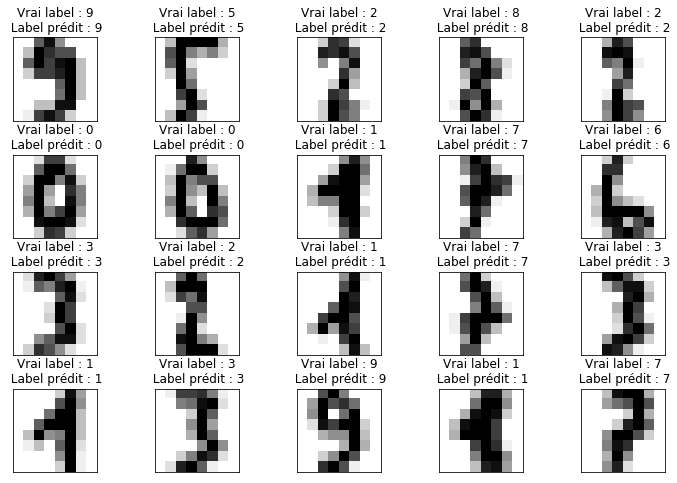

In [5]:
import random as rd

# Affiche 20 images aléatoire du set de données avec le label prédit et le vrai label
fig, ax = plt.subplots(4, 5, figsize=(12,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Prendre un index aléatoire dans les bornes du tableau d'images
i=rd.randint(0, X_kmeans.shape[0]-20)

for axi in ax.flat:
    axi.set(xticks=[], yticks=[])
    axi.set_title("Vrai label : %d\n Label prédit : %d"%(Y_kmeans[i],labels[i]))
    axi.imshow(np.reshape(X_kmeans[i],image_shape), interpolation='nearest', cmap=plt.cm.binary)
    i+=1

<font color="blue"/>


Comme nous pouvons le voir, les résultats entre les données attendues et les données calculées sont plutôt bons.
En effet, nous utilisons une fonction ```classification_report``` afin d'obtenir des informations concernant les métriques :

- Precision = 80% (moyenne) : à savoir quelle proportion d'identifications positives était effectivement correcte ? **TP/(TP+FP) : P(présent|detecté)**
- Rappel = 80% (moyenne) : à savoir quelle proportion de résultats positifs réels a été identifiée correctement ? **TP/(TP+FN) : P(detecté|présent)**
- Accuracy = 80% : à savoir le nombre total de corrections correctes sur le nombre de corrections effectuées **(TP+TN)/Tout : P(d'avoir juste)**

Comme nous pouvons le voir, toutes les métriques sont à 80%, ce qui est correct mais peut être amélioré. En effet, nous pouvons voir dans la matrice de confusion que certaines classes ont tendance à mal être classifiées comme la classe 1 qui a des prédictions confondues avec la classe 8. Cela fait sens dans la mesure où le centroid de la classe 1 et 8 se ressemblent. Mais la classe 8 et 9 sont aussi de mauvais résultats : elles sont confondues assez souvent et ont une précision et un rappel assez faible.

------------------------------------

La fonction nous donne aussi les informations concernant le f1-score à savoir la moyenne harmonique entre la precision et le rappel. Cette information nous dit si notre classificateur est précis ou pas et s'il est robuste. Avoir une précision élevée mais un rappel faible nous donne une accuracy très forte mais rates un grand nombre d'instances difficiles à classifier. Ce score est un bon équilibre entre les deux.

------------------------------------

On peut en conclure que cette méthode peut s'apparenter à une bonne méthode au départ :
- on connait déjà le nombre de classes initial
- les vecteurs ont une taille modulable : on exploite bien cet avantage avec nos vecteurs de taille 8\*8
- les centroids nous donne des résultats pertinents et visibles pour l'humain

Cependant, comme nous montre la matrice de confusion et les résultats des métriques obtenus, nous savons qu'il est possible de faire mieux.

De plus, KMeans est un outil **non supervisé** ayant pour but de rassembler les données selon des centroids (points dans l'espace) proches des données en N clusters différents.
Ici, nous connaissons la correspondance entre les labels et les images, et donc il serait peut être plus pertinent d'utiliser un modèle de *machine learning* **supervisé**.

<font color="blue"/>

### Question 2 : Naïve Bayes

La classification naïve bayésienne, ou Naive Bayes, est une méthode de classification **supervisée**. Le but est toujours de séparer les données en différentes classes en s'entraînant sur des données pour lesquelles on connaît la classe d'appartenance. Le but est d'établir des probabilités selon lesquelles certaines caractéristiques peuvent apparaître selon des conditions.
Le but ici est de séparer les 10 classes selon une fonction d'hyperplan selon un ensemble de données d'entraînements.

Cependant il faut attention à bien proportionner le rapport entre le nombre de données avec lequel l'algortihme s'entraîne et celui avec lequel il teste. En effet, nous pouvons être amenés à de :
- overfitting : fonctions de séparation beaucoup trop adapté au modèle d'entraîenemt et donc peut ne pas prendre en compte des valeurs qui sont proches d'autres classes
- underfitting : le modèle est trop simple pour représenter toutes les caractéristiques des classes

Durant la phase d'apprentissage il faut donc laisser une certaine flexibilité afin de pouvoir s'adapter aux données n'appartenant pas théoriquement dans une classe bien que très proche de celle dans laquelle elles devraient être.

Nous allons tester les différentes méthodes en changeant les paramètres suivants et en sélectionnant le meilleur :
- taille relative des données de tests (30%,70%)
- gaussienne ou multinomiale


In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X_bayes=digits.data
Y_bayes=digits.target

# Séparer les données d'entraînemetn avec celles de tests avec une taille de test égale à 30% des données initiales
X_train, X_test, Y_train, Y_test = train_test_split(X_bayes, Y_bayes, test_size=0.3, random_state=0)

nb = MultinomialNB()

# S'entraîne (fit) sur les données d'entraînement et on prédit les valeurs que l'on aura
# concernant les données de test : labels prédits
pred_multiNB = nb.fit(X_train,Y_train).predict(X_test)

print("Nombre de tests : %d"%X_test.shape[0])
print("Nombre d'erreurs : %d"%(Y_test != pred_multiNB).sum())


Nombre de tests : 540
Nombre d'erreurs : 51


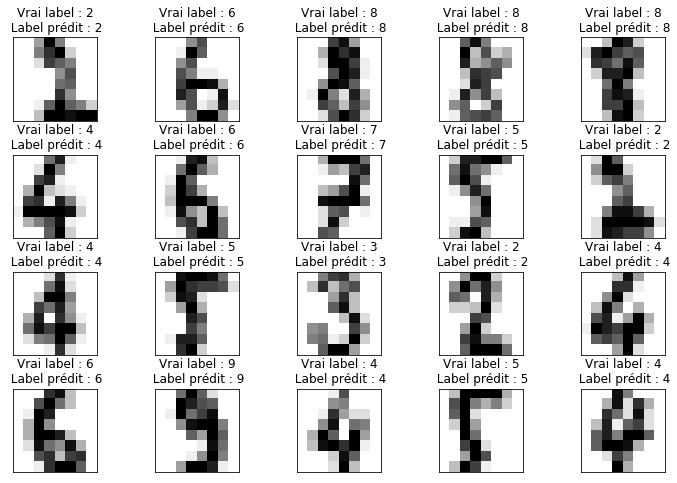

In [7]:
fig, ax = plt.subplots(4, 5, figsize=(12,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Prendre un index aléatoire dans les bornes du tableau d'images
i=rd.randint(0, X_test.shape[0]-20)

for axi in ax.flat:
    axi.set(xticks=[], yticks=[])
    axi.set_title("Vrai label : %d\n Label prédit : %d"%(Y_test[i],pred_multiNB[i]))
    axi.imshow(np.reshape(X_test[i],image_shape), interpolation='nearest', cmap=plt.cm.binary)
    i+=1

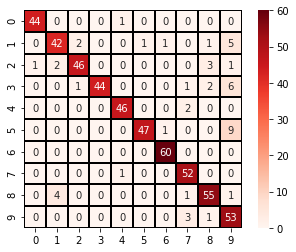

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        45
           1       0.88      0.81      0.84        52
           2       0.94      0.87      0.90        53
           3       1.00      0.81      0.90        54
           4       0.96      0.96      0.96        48
           5       0.98      0.82      0.90        57
           6       0.97      1.00      0.98        60
           7       0.88      0.98      0.93        53
           8       0.89      0.90      0.89        61
           9       0.71      0.93      0.80        57

    accuracy                           0.91       540
   macro avg       0.92      0.91      0.91       540
weighted avg       0.92      0.91      0.91       540



In [8]:
# Nous obtenons les résultats dans la matrice de confusion
confution_matrix_multiNB = metrics.confusion_matrix(Y_test, pred_multiNB, labels=range(n_clusters))

# On l'affiche sur une heatmap
ax = heatmap(confution_matrix_multiNB, annot=True, cmap="Reds", square=True, linecolor="black", fmt='d', linewidths = 1)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()
    
report_multiNB = metrics.classification_report(Y_test, pred_multiNB)
print(report_multiNB)

<font color="blue"/>

Ici on fait une classification naïve bayésienne selon un algorithme Multinomial. Ce dernier change notamment la formule utilisée afin de calculer les probabilités conditionnelles. Cette méthode de calcul est plus efficace quand il s'agit de calculer des valeurs discrètes.

Comme nous pouvons le voir sur les résultat, nous avons une meilleur accuracy globale à savoir 91% des données prédites sont correctes.

Un autre avantage avec cette méthode est que la précision pour les chiffres 3, 4 et 6 est toujours parfaite.

Nombre de tests : 1438
Nombre d'erreurs : 152


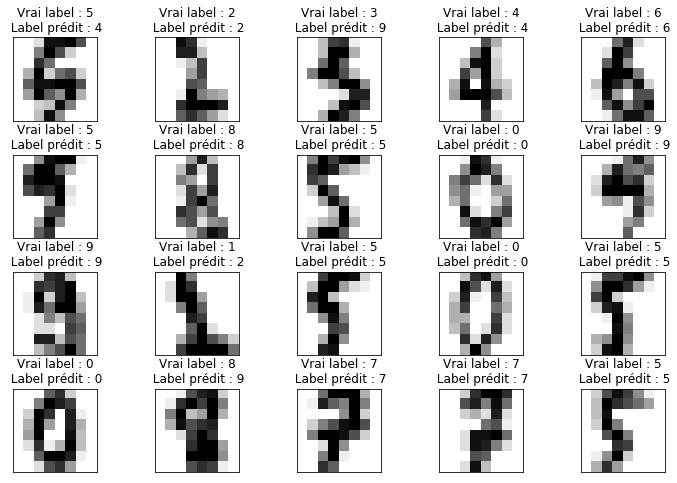

In [9]:
# On fait la meme chose en prenant un grand nombre de tests 80%
X_train, X_test, Y_train, Y_test = train_test_split(X_bayes, Y_bayes, test_size=0.8, random_state=0)

nb = MultinomialNB()

pred_multiNB = nb.fit(X_train,Y_train).predict(X_test)

print("Nombre de tests : %d"%X_test.shape[0])
print("Nombre d'erreurs : %d"%(Y_test != pred_multiNB).sum())

fig, ax = plt.subplots(4, 5, figsize=(12,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

i=rd.randint(0, X_test.shape[0]-20)

for axi in ax.flat:
    axi.set(xticks=[], yticks=[])
    axi.set_title("Vrai label : %d\n Label prédit : %d"%(Y_test[i],pred_multiNB[i]))
    axi.imshow(np.reshape(X_test[i],image_shape), interpolation='nearest', cmap=plt.cm.binary)
    i+=1

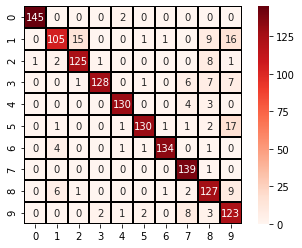

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       0.89      0.71      0.79       147
           2       0.88      0.91      0.89       138
           3       0.98      0.85      0.91       150
           4       0.96      0.95      0.96       137
           5       0.96      0.85      0.90       153
           6       0.98      0.95      0.96       141
           7       0.87      0.99      0.93       140
           8       0.79      0.87      0.83       146
           9       0.71      0.88      0.79       139

    accuracy                           0.89      1438
   macro avg       0.90      0.90      0.90      1438
weighted avg       0.90      0.89      0.89      1438



In [10]:
# Nous obtenons les résultats dans la matrice de confusion
confution_matrix_multiNB = metrics.confusion_matrix(Y_test, pred_multiNB, labels=range(n_clusters))

# On l'affiche sur une heatmap
ax = heatmap(confution_matrix_multiNB, annot=True, cmap="Reds", square=True, linecolor="black", fmt='d', linewidths = 1)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()
    
report_multiNB = metrics.classification_report(Y_test, pred_multiNB)
print(report_multiNB)

<font color="blue"/>

Augmenter le nombre de tests réduit nos métriques (pas une bonne nouvelle) mais c'est relativement faible. D'autant plus qu'en agumentant le nombre de tests, on peut facilement voir sur la matrice de confusion, quelles classes sont confondues entre elles et il s'agit du 1 et du 9.

Avec cette méthode, nous avons calculé empiriquement et c'est a partir de + de 30% de tests que nos métriques diminuent. Nous allons donc rester à 30% de tests. C'est un choix à faire et nous considérons que s'entraîner un peu mais pas trop est un bon compromis afin de voir les comportements dans les confusions.

In [11]:
'''from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

y = label_binarize(Y_bayes, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y.shape[1]

classifier = OneVsRestClassifier(nb)
classifier.fit(X_train, Y_train)

y_score = classifier.decision_function(X_test)


precision = dict()
recall = dict()

for i in range(n_clusters):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:,i],
                                                        y_score[:,i])
plt.show()

for i in range(n_clusters):
    plt.plot(recall[i],precision[i])
    '''

'from sklearn.preprocessing import label_binarize\nfrom sklearn.multiclass import OneVsRestClassifier\n\ny = label_binarize(Y_bayes, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])\nn_classes = y.shape[1]\n\nclassifier = OneVsRestClassifier(nb)\nclassifier.fit(X_train, Y_train)\n\ny_score = classifier.decision_function(X_test)\n\n\nprecision = dict()\nrecall = dict()\n\nfor i in range(n_clusters):\n    precision[i], recall[i], _ = precision_recall_curve(Y_test[:,i],\n                                                        y_score[:,i])\nplt.show()\n\nfor i in range(n_clusters):\n    plt.plot(recall[i],precision[i])\n    '

<font color="blue"/>

---------------------------------------

Nous allons essayer de faire la même chose avec cette fois ci la méthode Gaussiène.

In [12]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, Y_train, Y_test = train_test_split(X_bayes, Y_bayes, test_size=0.2, random_state=0)

gnb = GaussianNB()
pred_gaussianNB = gnb.fit(X_train,Y_train).predict(X_test)

print("Nombre de tests : %d"%X_test.shape[0])
print("Nombre d'erreurs : %d"%(Y_test != pred_gaussianNB).sum())

Nombre de tests : 360
Nombre d'erreurs : 63


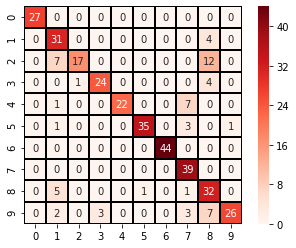

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.66      0.89      0.76        35
           2       0.94      0.47      0.63        36
           3       0.89      0.83      0.86        29
           4       1.00      0.73      0.85        30
           5       0.97      0.88      0.92        40
           6       1.00      1.00      1.00        44
           7       0.74      1.00      0.85        39
           8       0.54      0.82      0.65        39
           9       0.96      0.63      0.76        41

    accuracy                           0.82       360
   macro avg       0.87      0.82      0.83       360
weighted avg       0.87      0.82      0.83       360



In [13]:
# Nous obtenons les résultats dans la matrice de confusion
confution_matrix_gaussianNB = metrics.confusion_matrix(Y_test, pred_gaussianNB, labels=range(n_clusters))

# On l'affiche sur une heatmap
ax = heatmap(confution_matrix_gaussianNB, annot=True, cmap="Reds", square=True, linecolor="black", fmt='d', linewidths = 1)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()
    
report_gaussianNB = metrics.classification_report(Y_test, pred_gaussianNB)
print(report_gaussianNB)

<font color="blue"/>

### Question 3 : SVM

Le but de cette classification est de séparer les données selon des hypers plans afin d'avoir des groupes de données selon les 10 classes existantes. Cet algorithme supervisé a pour but de maximiser les marges entre les hyperplans et les échantillons les plus proches (vecteurs de support). Dans la méthode SVM, les frontières entre les classes sont choisies selon les marges **maximales**.

Ici, on utilisera les 1757 premières données afin de s'entraîner (données qui à chaque exécution seront aléatoires compte tenu de la permutation des indices initiale) et on testera ensuite sur les 20 dernières données de notre dataset.

Nous allons essayer de visualiser les différentes classification SVM afin de voir laquelle est potentiellement la meilleure : linéaire, non linaire ou RBF (*Radial basis function*). De plus, nous allons essayer les différentes méthodes avec des paramètres différents pouvant influencer les résultats :
- degré : pour la méthode polynomiale
- gamma : pour toutes les méthodes
- kernel

In [14]:
from sklearn import svm

X_svm=digits.data
Y_svm=digits.target

# Séparer les données d'entraînement et tests 30% de tests
X_svm_train, X_svm_test, Y_svm_train, Y_svm_test = train_test_split(X_svm, Y_svm, test_size=0.3, random_state=0)

svc = svm.SVC(kernel='linear', C=1.0)
pred_linear_svm = svc.fit(X_svm_train,Y_svm_train).predict(X_svm_test)

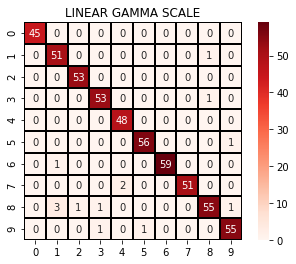

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.93      0.98      0.95        52
           2       0.98      1.00      0.99        53
           3       0.96      0.98      0.97        54
           4       0.96      1.00      0.98        48
           5       0.98      0.98      0.98        57
           6       1.00      0.98      0.99        60
           7       1.00      0.96      0.98        53
           8       0.96      0.90      0.93        61
           9       0.96      0.96      0.96        57

    accuracy                           0.97       540
   macro avg       0.97      0.98      0.97       540
weighted avg       0.97      0.97      0.97       540



In [15]:
# Nous obtenons les résultats dans la matrice de confusion
confution_matrix_linear_svm = metrics.confusion_matrix(Y_svm_test, pred_linear_svm, labels=range(n_clusters))
ax = heatmap(confution_matrix_linear_svm, annot=True, cmap="Reds", square=True, linecolor="black", fmt='d', linewidths = 1)
ax.set_title("LINEAR GAMMA SCALE")

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()
    
report_linear_svm = metrics.classification_report(Y_svm_test, pred_linear_svm)
print(report_linear_svm)

D:\Program Files (x86)\conda\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Legend does not support 0 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
D:\Program Files (x86)\conda\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Legend does not support 1 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
D:\Program Files (x86)\conda\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
D:\Program Files (x86)\conda\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Legend does not support 3 instances.
A proxy artist may be used i

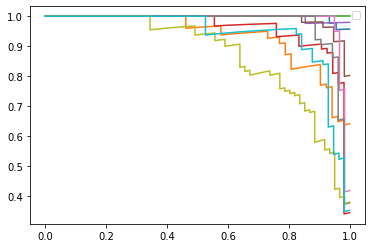

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Pour toutes les labels des images : binarise selon les classes : y contiendra 10 tableaux de toutes les labels en binaire avec
# y[i] = 1 si i = Y_svm[i]
y = label_binarize(Y_svm, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

X_svm_train, X_svm_test, Y_svm_train, Y_svm_test = train_test_split(X_svm, y, test_size=0.3, random_state=0)

# Faire des classifications pour chacune des classes 1 par rapport à toutes les autres
classifier = OneVsRestClassifier(svc)
classifier.fit(X_svm_train, Y_svm_train)

pred_labels = classifier.decision_function(X_svm_test)

precision = dict()
recall = dict()
average_precision = dict()

# Pour chaque classe, on va stocker la courbe de la précision en fonction du rappel
for i in range(n_clusters):
    # On passe en paramètre toutes les valeurs des vrais labels et le score associé pour chaque classe
    precision[i], recall[i], _ = precision_recall_curve(Y_svm_test[:, i], pred_labels[:, i])
    average_precision[i] = average_precision_score(Y_svm_test[:,i],pred_labels[:,i])
    
labels = dict()
lines = dict()

plt.show()

# On ajoute des légendes pour chacune des courbes
for i in range(n_clusters):
    l = plt.plot(recall[i],precision[i])
    lines[i] = l
    labels[i] = 'Precision-recall for class {0} (area = {1:0.2f})'.format(i, average_precision[i])
                
plt.legend(lines,labels)

<font color="blue"/>

En lanceant un algorithme SVM linéaire, nous obtenons de très bons résultats sur pratiquement toutes les classes. L'accuracy, précision et rappel nous donne des valeurs très acceptables.

Voyons si l'on change le nombre de tests à 80% ce qu'il se passe.

In [ ]:
from sklearn import svm

X_svm=digits.data
Y_svm=digits.target

# Séparer les données d'entraînement et tests 80% de tests
X_svm_train, X_svm_test, Y_svm_train, Y_svm_test = train_test_split(X_svm, Y_svm, test_size=0.8, random_state=0)

svc = svm.SVC(kernel='linear', C=1.0)
pred_linear_svm = svc.fit(X_svm_train,Y_svm_train).predict(X_svm_test)

# Nous obtenons les résultats dans la matrice de confusion
confution_matrix_linear_svm = metrics.confusion_matrix(Y_svm_test, pred_linear_svm, labels=range(n_clusters))
ax = heatmap(confution_matrix_linear_svm, annot=True, cmap="Reds", square=True, linecolor="black", fmt='d', linewidths = 1)
ax.set_title("LINEAR GAMMA SCALE")

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()
    
report_linear_svm = metrics.classification_report(Y_svm_test, pred_linear_svm)
print(report_linear_svm)

<font color="blue"/>

Encore une fois, on perd un peu de précision mais on voit clairement que sur le long terme (le nombre de tests) notre modèle s'est bien adapté et les valeurs sont correctes. Nous allons donc garder 80% de tests dans la mesure où la precision ne diminue que très peu.

---------------------------

Maintenant nous allons utiliser la méthode polynomiale, à savoir représenter les données dans un espace de degré polynomial plus grand que celui des variables d'origine permettant donc un apprentissage de modèles non-linéaires.

In [ ]:
# Degré 2
svc = svm.SVC(kernel='poly', degree=2, C=1.0)

pred_poly_svm = svc.fit(X_svm_train,Y_svm_train).predict(X_svm_test)

confution_matrix_poly_svm = metrics.confusion_matrix(Y_svm_test, pred_poly_svm, labels=range(n_clusters))
ax = heatmap(confution_matrix_poly_svm, annot=True, cmap="Reds", square=True, linecolor="black", fmt='d', linewidths = 1)
ax.set_title("POLY 2 GAMMA SCALE")

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

report_poly_svm = metrics.classification_report(Y_svm_test, pred_poly_svm)
print(report_poly_svm)

In [ ]:
# Degré 3
svc = svm.SVC(kernel='poly', degree=3, C=1.0)

pred_poly_svm = svc.fit(X_svm_train,Y_svm_train).predict(X_svm_test)

confution_matrix_poly_svm = metrics.confusion_matrix(Y_svm_test, pred_poly_svm, labels=range(n_clusters))
ax = heatmap(confution_matrix_poly_svm, annot=True, cmap="Reds", square=True, linecolor="black", fmt='d', linewidths = 1)
ax.set_title("POLY 3 GAMMA SCALE")

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

report_poly_svm = metrics.classification_report(Y_svm_test, pred_poly_svm)
print(report_poly_svm)

<font color="blue"/>

Comme on peut le voir, plus on augmente le degré, plus les métriques sont meilleures. Cependant, cela peut entraîner plusieurs problèmes comme notamment celui du surapprentissage et donc nous donner des mauvais résultats.


In [ ]:
# Degré 3
svc = svm.SVC(kernel='poly', degree=10, C=1.0)

pred_poly_svm = svc.fit(X_svm_train,Y_svm_train).predict(X_svm_test)

confution_matrix_poly_svm = metrics.confusion_matrix(Y_svm_test, pred_poly_svm, labels=range(n_clusters))
ax = heatmap(confution_matrix_poly_svm, annot=True, cmap="Reds", square=True, linecolor="black", fmt='d', linewidths = 1)
ax.set_title("POLY 10 GAMMA SCALE")

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

report_poly_svm = metrics.classification_report(Y_svm_test, pred_poly_svm)
print(report_poly_svm)

<font color="blue"/>

Comme on peut le voir, les métriques sont moins bonnes. Encore une fois, la raison peut être que nous avons surappris et donc le modèle s'adapte mal aux données test.

-----------------------

On va tester maintenant le noyau RBF : Radius Basis Function avec un gamma = scale : 1 / (N * X.var())

In [ ]:
# RBF
# gamma = scale
svc = svm.SVC(kernel='rbf', C=1.0)

pred_poly_svm = svc.fit(X_svm_train,Y_svm_train).predict(X_svm_test)

confution_matrix_poly_svm = metrics.confusion_matrix(Y_svm_test, pred_poly_svm, labels=range(n_clusters))
ax = heatmap(confution_matrix_poly_svm, annot=True, cmap="Reds", square=True, linecolor="black", fmt='d', linewidths = 1)
ax.set_title("RBF GAMMA SCALE")

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

report_poly_svm = metrics.classification_report(Y_svm_test, pred_poly_svm)
print(report_poly_svm)

<font color="blue"/>

Cette méthode nous donne de très bons résultats concernant chacune des classes (0.96 de précision en moyenne).

---------------------------

Cependant, le paramètre **gamma** peut aussi influencer sur les résultats. Il correspond à un paramètre utile pour les hyperplans non linéaires. Plus la valeur est grande, plus l'algorithme essaye de s'adapter au jeu de données d'entraînement.

Nous allons essayer avec la valeur "auto" correspondant à auto soit : 1 / N

In [ ]:
# RBF
svc = svm.SVC(kernel='rbf', C=1.0, gamma='auto')

pred_poly_svm = svc.fit(X_svm_train,Y_svm_train).predict(X_svm_test)

confution_matrix_poly_svm = metrics.confusion_matrix(Y_svm_test, pred_poly_svm, labels=range(n_clusters))
ax = heatmap(confution_matrix_poly_svm, annot=True, cmap="Reds", square=True, linecolor="black", fmt='d', linewidths = 1)
ax.set_title("RBF GAMMA AUTO")

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

report_poly_svm = metrics.classification_report(Y_svm_test, pred_poly_svm)
print(report_poly_svm)

<font color="blue"/>

Comme on peut le voir, si l'on passe à un gamma automatique, nous avons des résultats mauvais en confondant toutes les classes avec la classe 4. Le fait que les résultats soient tous confondus avec 4 reste cependant obscur, nous n'avons pas de réponses.

-------------------

Essayons maintenant avec un gamma > 1.

In [ ]:
# POLY GAMMA 5
svc = svm.SVC(kernel='poly', C=1.0, gamma=5)

pred_poly_svm = svc.fit(X_svm_train,Y_svm_train).predict(X_svm_test)

confution_matrix_poly_svm = metrics.confusion_matrix(Y_svm_test, pred_poly_svm, labels=range(n_clusters))
ax = heatmap(confution_matrix_poly_svm, annot=True, cmap="Reds", square=True, linecolor="black", fmt='d', linewidths = 1)
ax.set_title("POLY GAMMA 5")

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

report_poly_svm = metrics.classification_report(Y_svm_test, pred_poly_svm)
print(report_poly_svm)

<font color="blue"/>

Avec l'algorithme polynomial et un gamma à 5 (si on l'augmente cela ne change pas les résultats), nous obtenons des très bons résultats avec notamment une précision parfaite sur quelques classes et globalement il s'agit d'excellents résultats.

-------------------

Maintenant essayons de le faire avec une petite valeur.

In [ ]:
# POLY GAMMA 0.00001
svc = svm.SVC(kernel='poly', C=1.0, gamma=0.00001)

pred_poly_svm = svc.fit(X_svm_train,Y_svm_train).predict(X_svm_test)

confution_matrix_poly_svm = metrics.confusion_matrix(Y_svm_test, pred_poly_svm, labels=range(n_clusters))
ax = heatmap(confution_matrix_poly_svm, annot=True, cmap="Reds", square=True, linecolor="black", fmt='d', linewidths = 1)
ax.set_title("POLY GAMMA 5")

b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

report_poly_svm = metrics.classification_report(Y_svm_test, pred_poly_svm)
print(report_poly_svm)

<font color="blue"/>

Si l'on met un gamma beaucoup trop petit (< 0.00001) alors l'algorithme ne s'adaptera pas assez au données d'entraînement et alors nous aurons des mauvais résultats.